In [2]:
import torch
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import faiss
import copy
from typing import Tuple
import json

OUT_DIR = "../res/out"

"""
TODO:
apply function optimizations
"""

'\nTODO:\napply function optimizations\n'

In [ ]:
@dataclass
class Cuboid:
    # shape [3]
    center: torch.Tensor
    # shape [3]
    half_size: torch.Tensor
    # shape [1]
    yaw: torch.Tensor

def compute_rotation(yaw: torch.Tensor) -> torch.Tensor:
    # TODO: looks a bit hacky
    ZERO = torch.tensor([0])
    ONE = torch.tensor([1])

    c = torch.cos(yaw)
    s = torch.sin(yaw)

    return torch.stack([
        torch.stack([c, ZERO, s]),
        torch.stack([ZERO, ONE, ZERO]),
        torch.stack([-s, ZERO, c]),
    ]).float().squeeze()

# a hopefully more optimization friendly function
def compute_cuboid_dists2(points: torch.Tensor, cuboid: Cuboid) -> torch.Tensor:
    """
    Intuitively, optimizing this functions comes down to finding the cuboid face that
    is nearest to a point, and optimizing the cuboid parameters such that that face better
    fits the point.
    """

    # indices denoting the axes
    X, Y, Z = 0, 1, 2
    # the axes
    I = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])

    FACES = [
        # the tuple denotes which elementary vectors from the face's basis,
        #  and the last element the normalized vector from the face's center to the origin
        ((X, Y), Z, 1),
        ((X, Y), Z, -1),
        ((Z, Y), X, 1),
        ((Z, Y), X, -1),
        ((X, Z), Y, 1),
        ((X, Z), Y, -1),
    ]

    # move points to reference frame of the cuboid
    rot = compute_rotation(cuboid.yaw)
    cpoints = (points - cuboid.center) @ rot

    dists_to_faces = []
    for (i0, i1), offset_ax, v in FACES:
        # get normalized basis vectors of quad ([2 x 3])
        basis = I[[i0, i1], :]
        # project points onto basis ([N x 2])
        project_dists = cpoints @ basis.t()

        # compute distances orthogonal to plane ([1000]),
        #  because cuboid is axis aligned, the norm equals the sum
        orth_dists = ((cpoints - project_dists @ basis).sum(dim=1) - cuboid.half_size[offset_ax] * v).abs()

        # compute distance over the plane spanned by the quad ([1000])
        plane_dists = (project_dists - cuboid.half_size[[i0, i1]]).max(torch.tensor(0.0)).norm(dim=1)

        # get total distances
        dists_to_faces.append((torch.stack([orth_dists, plane_dists], dim=1)).norm(dim=1))
        
    # take minimum distances
    return torch.min(torch.stack(dists_to_faces, dim=1), dim=1).values # TODO:

def compute_cuboid_dists(points: torch.Tensor, cuboid: Cuboid) -> torch.Tensor:
    """
    # Params
    * `points`: Of shape [N x 3]
    * `cuboid`: Cuboid object with center, size, and yaw

    # Returns
    A tensor of distances of shape [N]
    """

    # move points to reference frame of cube
    rot = compute_rotation(cuboid.yaw)
    rot_points = (points - cuboid.center) @ rot # TODO: rename

    abs_points = torch.abs(rot_points)

    # test if points are inside the cube; 1 denotes inliers and 2 denotes outliers
    inliers = (abs_points <= cuboid.half_size).all(dim=1).float()

    # distances for outliers:
    #  compute the distance per axis, then take euclidean norm over coords
    outlier_dists = torch.max(abs_points - cuboid.half_size, torch.tensor(0.0)).norm(dim=1)

    # distances for inliers:
    #  take the distance to the closest cube face 
    inlier_dists = torch.min(cuboid.half_size - abs_points, dim=1).values

    # for each point, select whether outlier or inlier distance is applicable
    return inliers * inlier_dists + (1 - inliers) * outlier_dists

def cuboid_L1_loss(points: torch.Tensor, cube: Cuboid) -> torch.Tensor:
    return torch.mean(compute_cuboid_dists2(points, cube))

def cuboid_L2_loss(points: torch.Tensor, cube: Cuboid) -> torch.Tensor:
    return torch.mean(compute_cuboid_dists2(points, cube)**2)

In [3]:
def gen_points(cube: Cuboid, n=100) -> torch.Tensor:
    pos_list = []
    for _ in range(n):
        # compute offset
        pos = torch.rand((3,)) * 2 - 1

        # select center of random face
        idx = torch.randint(0, 3, (1,)).item()
        pos[idx] = torch.randint(0, 2, (1,)).item() * 2 - 1

        # rotate, scale and translate
        pos = compute_rotation(cube.yaw) @ pos * cube.half_size + cube.center

        pos_list.append(pos + cube.center) # TODO: rotate

    return torch.stack(pos_list)

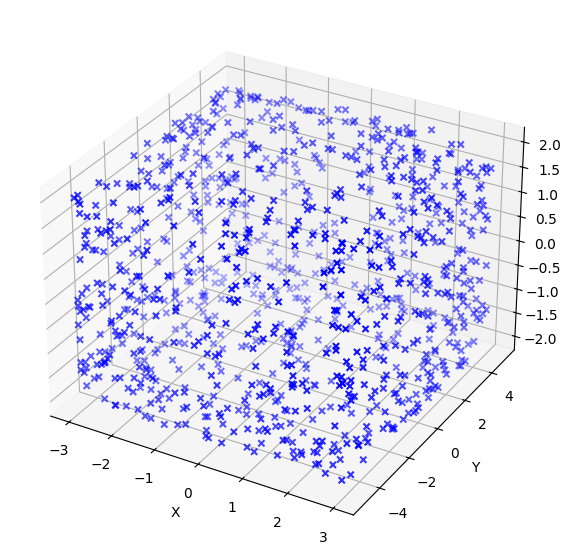

tensor(0.)

In [4]:
TARGET_CENTER = torch.tensor([0., 0., 0.])
TARGET_HALFSIZE = torch.tensor([5., 2., 3.])
TARGET_YAW = torch.tensor([0.0]) # TODO: 0.9

target_cube = Cuboid(
    TARGET_CENTER, TARGET_HALFSIZE, TARGET_YAW
)

points = gen_points(target_cube, 1000)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(points[:, 2], points[:, 0], points[:, 1], c="blue", marker="x")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

compute_cuboid_dists2(points, target_cube).mean()

In [4]:
data = json.load(open(f"{OUT_DIR}/pretty_point_cloud.json", "r"))
points = np.array([
    point["pos"] for point in data
], np.float32)

Removed 310, norm [0.00433707 0.02313807 0.9997229 ]


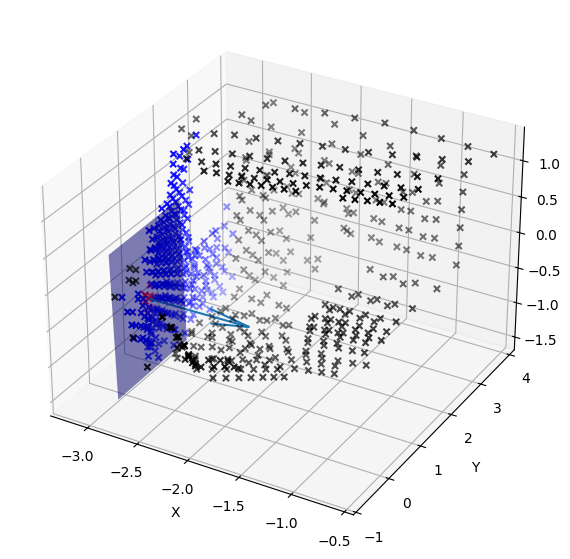

Removed 101, norm [ 0.0025889   0.99990076 -0.01385   ]


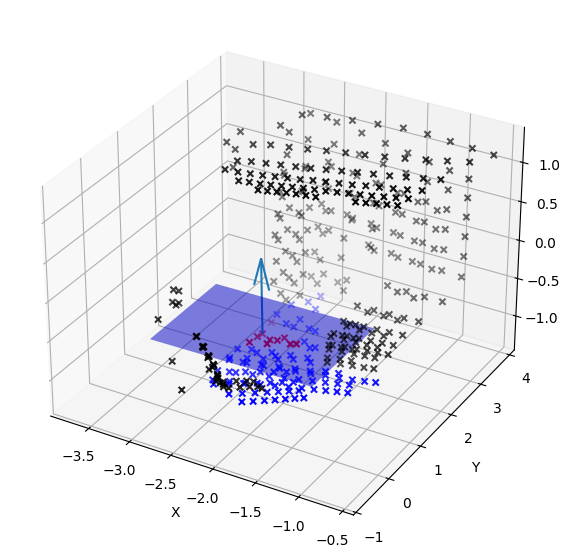

Removed 83, norm [ 0.00453337  0.9997687  -0.02102394]


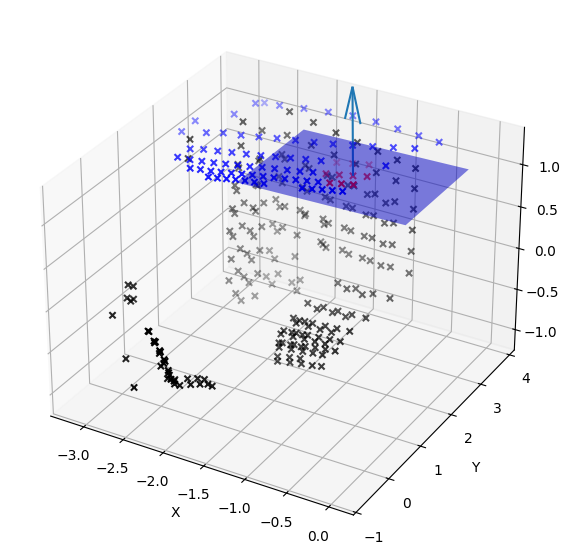

Removed 78, norm [ 0.9977986  -0.06049147 -0.02717942]


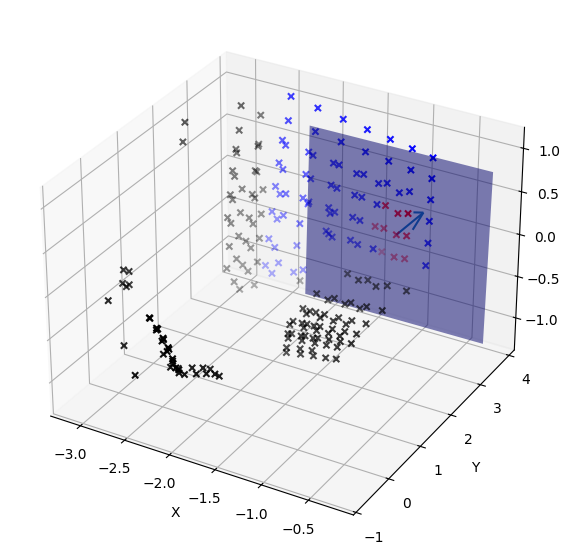

Failed to fit plane...


[((array([ 0.49765897, -0.4874451 , -2.9193776 ], dtype=float32),
   array([0.00433707, 0.02313807, 0.9997229 ], dtype=float32)),
  310),
 ((array([ 2.2241688, -1.2571152, -2.7436304], dtype=float32),
   array([ 0.0025889 ,  0.99990076, -0.01385   ], dtype=float32)),
  101),
 ((array([ 1.9933567 ,  1.2388548 , -0.94760406], dtype=float32),
   array([ 0.00453337,  0.9997687 , -0.02102394], dtype=float32)),
  83),
 ((array([ 3.767203 , -0.2255896, -1.2388598], dtype=float32),
   array([ 0.9977986 , -0.06049147, -0.02717942], dtype=float32)),
  78)]

In [9]:
"""
Apply Ransac to find optimal 6 planes.

During each iteration, we sample 1 single point.
From its neighborhood, we compute a plane equation which is evaluated on the number of inliers.
"""

def build_index(points: np.ndarray):
    point_index = faiss.index_factory(3, "Flat")
    point_index.train(points)
    point_index.add(points)
    return point_index

def compute_normal(point: np.ndarray, points: np.ndarray, point_index, k_neighbor: int) -> np.ndarray:
    """ Returns the normalized estimated normal of a point. """
    # select point's neighborhood
    _, inds = point_index.search(np.atleast_2d(point), k_neighbor)
    ps = points[inds].squeeze()
    # compute normal of plane (i.e., third eigenvector)
    pca = faiss.PCAMatrix(3, 3)
    pca.train(ps)
    return faiss.vector_to_array(pca.A)[6:]

def compute_inliers(
        plane_point: np.ndarray, plane_norm: np.ndarray, points: np.ndarray,
        threshold: float,
    ) -> np.ndarray:
    """
    Returns the indices of inliers.

    # Params:
    * `plane_point`: point on the plane of shape [3]
    * `plane_norm`: normalized normal vector of shape [3]
    * `points`: sample group of shape [N, 3]

    # Returns
    An array of shape [N]
    """
    
    dists = np.abs((points - plane_point) @ plane_norm)
    return np.where(dists < threshold)[0]

def mesh_from_plane(
    plane_center: np.ndarray, plane_norm: np.ndarray, extent=1.0
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # get vector linearly independent from normal
    min_idx = np.argmin(np.abs(plane_norm))
    v = np.zeros_like(plane_norm)
    v[min_idx] = 1

    # get direction vectors of plane
    dir0 = np.cross(plane_norm, v)
    dir0 /= np.linalg.norm(dir0)

    dir1 = np.cross(plane_norm, dir0)
    dir1 /= np.linalg.norm(dir1)

    # create a grid of points on the plane
    xx, yy = np.meshgrid(
        np.linspace(-extent, extent, 2), 
        np.linspace(-extent, extent, 2)
    )
    
    # Map the grid to 3D points on the plane
    points = plane_center + xx[:, :, np.newaxis] * dir0 + yy[:, :, np.newaxis] * dir1
    
    # Extract x, y, z coordinates for plotting
    x = points[:, :, 0]
    y = points[:, :, 1]
    z = points[:, :, 2]
    return x, y, z

N_ITER = 100
# TODO: rename
K_NEIGHBOR = 10
MIN_INLIERS = 65
THRESH = 0.1

ransac_points = copy.deepcopy(points)

point_index = build_index(ransac_points)

fits = []
for _ in range(6):
    best_fit, top_inlier_count = None, MIN_INLIERS-1
    
    for _ in range(N_ITER):
        # sample random point
        point = ransac_points[np.random.randint(0, ransac_points.shape[0])]
        # estimate normal
        norm = compute_normal(point, ransac_points, point_index, K_NEIGHBOR)

        # evaluate plane
        inliers = compute_inliers(point, norm, ransac_points, THRESH)
        inlier_count = inliers.shape[0]

        if inlier_count > top_inlier_count:
            best_fit = (point, norm)
            top_inlier_count = inlier_count

    if best_fit is None:
        print("Failed to fit plane...")
        break

    # add fit # TODO: recalculate plane?
    fits.append((best_fit, top_inlier_count))

    # remove inliers so that we can find the next best fit
    point, norm = best_fit
    inliers = compute_inliers(point, norm, ransac_points, THRESH)

    # TODO: remove plotting
    # 
    # find neighbors
    _, inds = point_index.search(np.atleast_2d(point), K_NEIGHBOR)
    ps = ransac_points[inds].squeeze()

    # remove neighbors and inliers from points
    mask_ = np.ones_like(ransac_points, bool)
    mask_[inliers] = False
    mask_[inds] = False
    plot_points = ransac_points[mask_].reshape(-1, 3)

    # remove neighbors from inliers
    mask_ = np.zeros_like(ransac_points, bool)
    mask_[inliers] = True
    mask_[inds] = False
    inlier_points = ransac_points[mask_].reshape(-1, 3)

    print(f"Removed {inliers.shape[0]}, norm {norm}")
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(projection='3d')
    # ax.axes.set_xlim3d(left=-3.5, right=3.5)
    # ax.axes.set_ylim3d(bottom=-4.5, top=4.5) 
    # ax.axes.set_zlim3d(bottom=-2.5, top=2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    x, y, z = mesh_from_plane(point, norm, extent=1)
    ax.plot_surface(z, x, y, color="blue", alpha=0.5)

    ax.quiver(
        point[2], point[0], point[1], norm[2], norm[0], norm[1],
        arrow_length_ratio=0.4
    )
    ax.scatter(plot_points[:, 2], plot_points[:, 0], plot_points[:, 1], c="black", marker="x")
    ax.scatter(inlier_points[:, 2], inlier_points[:, 0], inlier_points[:, 1], c="blue", marker="x")
    ax.scatter(ps[:, 2], ps[:, 0], ps[:, 1], c="red", marker="x")
    
    plt.show()

    # TODO: **
    mask = np.ones_like(ransac_points, bool)
    mask[inliers] = False

    ransac_points = ransac_points[mask].reshape(-1, 3)
    point_index = build_index(ransac_points) # TODO: is just repeated calculations

fits


164

array([-1.5482548e-05,  2.7062929e-06,  1.0000000e+00], dtype=float32)

array([ 1.3520263e+00,  4.7016990e-01, -1.1812247e-10], dtype=float32)

array([[ 2.814538  , -0.45905662,  3.        ],
       [ 3.076322  , -0.5405688 ,  3.        ],
       [ 2.589482  , -0.67032146,  3.        ],
       [ 3.0985446 , -0.28056931,  3.        ],
       [ 3.0837011 , -0.6623316 ,  3.        ],
       [ 2.9592805 , -0.9205065 ,  3.        ],
       [ 3.0212712 , -0.01683807,  3.        ],
       [ 2.55185   , -0.0314045 ,  3.        ],
       [ 3.018924  ,  0.05652237,  3.        ],
       [ 2.4753916 , -1.0145836 ,  3.        ]], dtype=float32)

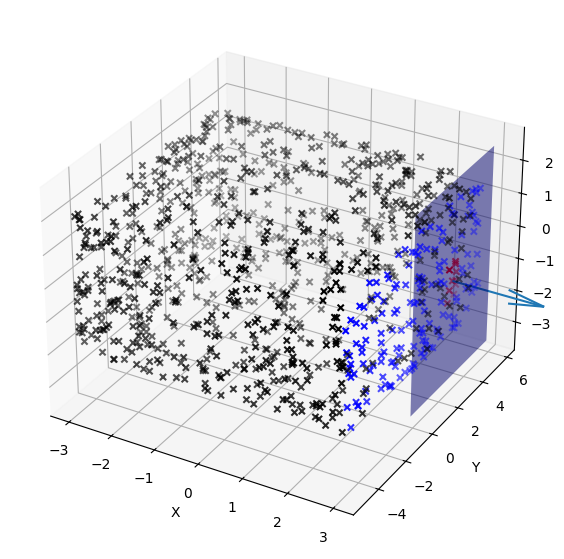

In [ ]:
"""
Showcases the normal and plane calculated for a random point.
"""

# sample random point
point_index = build_index(points)
p = points[np.random.randint(0, points.shape[0])]

# compute normal
_, inds = point_index.search(np.atleast_2d(p), K_NEIGHBOR)

ps = points[inds].squeeze()
pca = faiss.PCAMatrix(3, 3)
pca.train(ps)
norm = faiss.vector_to_array(pca.A)[6:] * 2
#norm = compute_normal(p, points, point_index, K_NEIGHBOR)

# find inliers
inliers = compute_inliers(p, norm, points, THRESH)

# remove neighbors from inliers
mask = np.zeros_like(points, bool)
mask[inliers] = True
mask[inds] = False
inlier_points = points[mask].reshape(-1, 3)

# remove neighbors and inliers from points
mask = np.ones_like(points, bool)
mask[inliers] = False
mask[inds] = False
plot_points = points[mask].reshape(-1, 3)

# plot
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')

ax.quiver(
    p[2], p[0], p[1], norm[2], norm[0], norm[1],
    arrow_length_ratio=0.4
)

ax.scatter(plot_points[:, 2], plot_points[:, 0], plot_points[:, 1], c="black", marker="x")
ax.scatter(inlier_points[:, 2], inlier_points[:, 0], inlier_points[:, 1], c="blue", marker="x")
ax.scatter(ps[:, 2], ps[:, 0], ps[:, 1], c="red", marker="x")

x, y, z = mesh_from_plane(p, norm, extent=3)
ax.plot_surface(z, x, y, color="blue", alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

display(inliers.shape[0], faiss.vector_to_array(pca.A)[6:], faiss.vector_to_array(pca.eigenvalues), ps)
plt.show()


Original attempt:
Use gradient descent on box parameters

In [16]:
# * trainings loop *
N_ITERS = 1500

# init
cuboid = Cuboid(
    center=torch.tensor([0.0, 0.0, 0.0], requires_grad=True), # TODO: init w/ cloud mean
    half_size=torch.tensor([1.0, 1.0, 1.0], requires_grad=True),
    yaw=torch.tensor([0.], requires_grad=True)
)

optimizer = torch.optim.Adam(
    # TODO: [cube.center, cube.half_size, cube.yaw], lr=3e-3
    [cuboid.half_size, cuboid.yaw], lr=1e-2
)

loss_list = []
for i in range(1, N_ITERS+1):
    optimizer.zero_grad()

    constrained_cube = Cuboid(
        center=cuboid.center,
        half_size=torch.relu(cuboid.half_size),
        yaw=cuboid.yaw
    )

    loss = cuboid_L1_loss(points, constrained_cube)
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

    if i % 200 == 0:
        print(f"iter {i} --> loss: {loss.item():.2}") 
    
print(f"true params: {target_cube}")
print(f"final params: {cuboid}")

plt.plot(loss_list) # TODO: make plots for param changes
plt.show()

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

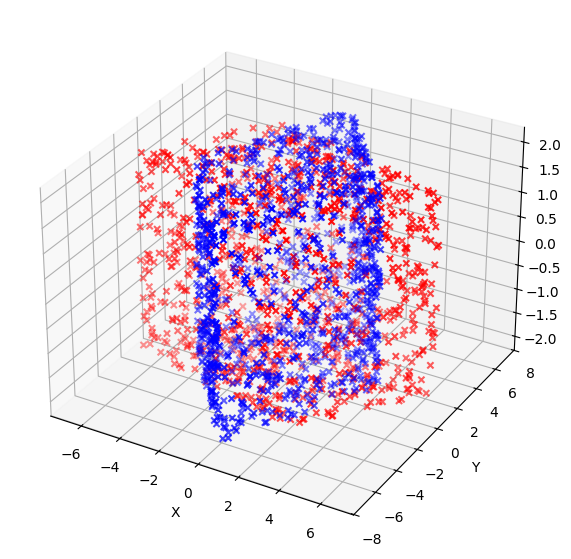

In [ ]:
pred_points = gen_points(cuboid, 1000).detach().numpy() # TODO: why is this necessary all of the sudden

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:, 2], points[:, 0], points[:, 1], c="blue", marker="x")
ax.scatter(pred_points[:, 2], pred_points[:, 0], pred_points[:, 1], c="red", marker="x")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
points = torch.tensor([[0.5, 0.5, 0.0], [10.0, 10.0, 10.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
cuboid = Cuboid(
    center=torch.tensor([0.0, 0.0, 0.0], requires_grad=True),
    half_size=torch.tensor([1.0, 1.0, 1.0], requires_grad=True),
    yaw=torch.tensor([0.], requires_grad=True)
)

compute_cuboid_dists2(points, cuboid),compute_cuboid_dists(points, cuboid),

(tensor([ 0.5000, 15.5885,  0.0000,  1.0000], grad_fn=<MinBackward0>),
 tensor([ 0.5000, 15.5885,  0.0000,  1.0000], grad_fn=<AddBackward0>))

In [ ]:
loss = cuboid_L1_loss(points, cuboid)
print(loss.item())

loss.backward()

cuboid.center.grad, cuboid.half_size.grad, cuboid.yaw.grad

4.2821149826049805


(tensor([ 0.1057, -0.1443,  0.1057]),
 tensor([ 0.1157, -0.1443,  0.1157]),
 tensor([0.]))